#Given a specific budget what genre movie should I make to gross the highest domestic profit?

In [62]:
%matplotlib inline
import pickle
from pprint import pprint
import pandas as pd
import numpy as np

###Load the movie dictionary

In [2]:
d = pickle.load(open('movie_dictionary.p'))

In [97]:
#Create a dataframe 
df = pd.DataFrame.from_dict(d, orient = 'index')

In [98]:
df.dtypes

gross          object
rating         object
distributor    object
budget         object
producers      object
genre          object
directors      object
writers        object
actors         object
date           object
runtime        object
dtype: object

In [153]:
df2 = df.copy()
df2 = df2[['gross', 'date', 'budget', 'genre', 'runtime']]


In [154]:
df2['gross'][df2.gross == 'N/A'] = np.nan

In [165]:
df2['runtime'][df2.runtime <= 0]

 Untitled Illumination Project 2 (2016) (2016)     None
$9.99 (2008)                                         78
$upercapitalist (2012)                               96
'71 (2015)                                           99
'N Sync: Bigger Than Live (IMAX) (2001)              47
'Neath the Arizona Skies (1934)                      52
'Night, Mother (1986)                                96
'R Xmas (2002)                                       83
'Round Midnight (1986)                              133
'Tis Autumn: The Search for Jackie Paris (2007)     100
(500) Days of Summer (2009)                          95
(Untitled) (2009)                                    96
* batteries not included (1987)                     106
...And Justice for All (1979)                       119
1 Mile Above (2013)                                  87
1+1=11 (2003)                                      None
1,000 Times Good Night (2014)                       117
10 (1979)                                       

In [161]:
df2['gross'][df2.gross == 'N/A'] = np.nan
df2['budget'][df2.budget == 'N/A'] = np.nan
df2['runtime'][df2.runtime == None] = np.nan
#df2 = df2[df2.date != 'N/A']
#df2 = df2[df2.genre != 'N/A']



In [137]:
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].apply(lambda x: x.year)
df2['gross'] = df2['gross'].astype(int)
df2['budget'] = df2['budget'].astype(int)
df2['runtime'] = df2['runtime'].astype(int)
df2['log_runtime'] = df2['runtime'].apply(lambda x: np.log(x))
df2['log_budget'] = df2['budget'].apply(lambda x: np.log(x))
df2['log_gross'] = df2['gross'].apply(lambda x: np.log(x))

###Check top grossing genres

In [124]:
df2.groupby('genre')[['log_gross', 'runtime']].sum().sort('log_gross', ascending = False)

,log_gross,runtime
genre,,
Comedy,5784.843699,33608
Drama,2902.030307,20872
Animation,2709.927658,13604
Thriller,2163.144286,13906
Romantic Comedy,2148.211842,13067
Horror,2131.934666,12424
Action,1820.357443,11332
Action / Adventure,1249.241169,8149
Comedy / Drama,1196.697022,7819


In [125]:
df2['Comedy'] = df2['genre'].apply(lambda x: 1 if 'Comedy' in x else 0)
df2['Horror'] = df2['genre'].apply(lambda x: 1 if 'Horror' in x else 0)
df2['Drama'] = df2['genre'].apply(lambda x: 1 if 'Drama' in x else 0)
df2['Thriller'] = df2['genre'].apply(lambda x: 1 if 'Thriller' in x else 0)
df2['Romance'] = df2['genre'].apply(lambda x: 1 if ('Romance' in x) or ('Romantic' in x) else 0)
df2['Sci_Fi'] = df2['genre'].apply(lambda x: 1 if 'Sci-Fi' in x else 0)
df2['Music'] = df2['genre'].apply(lambda x: 1 if 'Music' in x else 0)
df2['Action'] = df2['genre'].apply(lambda x: 1 if 'Action' in x else 0)



###Linear Regression

In [106]:
#y, X = dmatrices('gross ~ budget + Comedy + Horror + Drama + \
#                            Thriller + Romance + Sci_Fi + Music + Action', data=df2, return_type='dataframe')
y, X = dmatrices('log_gross ~ log_budget + year', data=df2, return_type='dataframe')

In [109]:
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:              log_gross   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     850.1
Date:                Tue, 06 Oct 2015   Prob (F-statistic):          9.89e-162
Time:                        13:10:58   Log-Likelihood:                -4713.8
No. Observations:                2575   AIC:                             9432.
Df Residuals:                    2573   BIC:                             9443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     16.1678      0.044    370.284      0.0

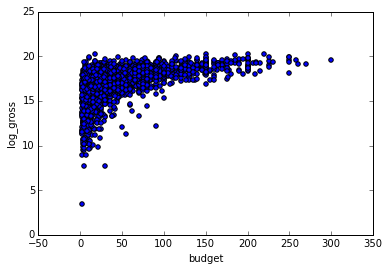

In [131]:
#budget vs log_gross
y, X = dmatrices('log_gross ~ budget', data=df2, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
df2.plot(x = 'budget', y = 'log_gross', kind = 'scatter')

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     878.2
Date:                Tue, 06 Oct 2015   Prob (F-statistic):          2.70e-166
Time:                        13:11:46   Log-Likelihood:                -49968.
No. Observations:                2575   AIC:                         9.994e+04
Df Residuals:                    2573   BIC:                         9.995e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -7.022e+07   4.64e+06    -15.121      0.0

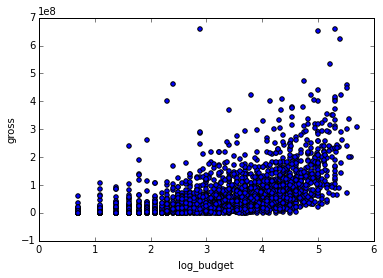

In [133]:
#log(budget) vs gross
y, X = dmatrices('gross ~ log_budget', data=df2, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
df2.plot(x = 'log_budget', y = 'gross', kind = 'scatter')

                            OLS Regression Results                            
Dep. Variable:              log_gross   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     1305.
Date:                Tue, 06 Oct 2015   Prob (F-statistic):          1.44e-231
Time:                        13:12:27   Log-Likelihood:                -4553.0
No. Observations:                2575   AIC:                             9110.
Df Residuals:                    2573   BIC:                             9122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.5666      0.102    133.397      0.0

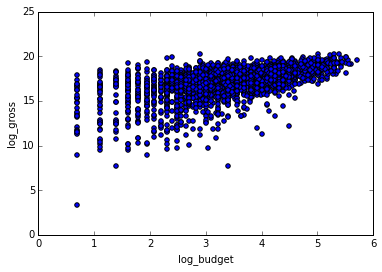

In [134]:
#log(budget) vs log(gross)
y, X = dmatrices('log_gross ~ log_budget', data=df2, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
df2.plot(x = 'log_budget', y = 'log_gross', kind = 'scatter')

                            OLS Regression Results                            
Dep. Variable:                runtime   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     182.2
Date:                Tue, 06 Oct 2015   Prob (F-statistic):           3.64e-40
Time:                        13:14:07   Log-Likelihood:                -11325.
No. Observations:                2575   AIC:                         2.265e+04
Df Residuals:                    2573   BIC:                         2.266e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    104.0662      0.569    182.905      0.0

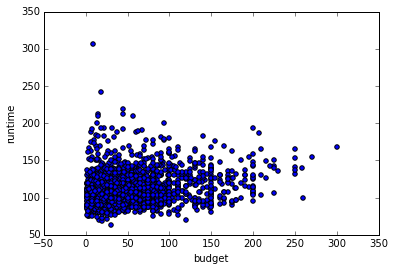

In [140]:
#budget vs runtime
y, X = dmatrices('runtime ~ budget', data=df2, return_type='dataframe')
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
df2.plot(x = 'budget', y = 'runtime', kind = 'scatter')